In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from koala.pointsets import uniform
from koala import graph_utils as gu
from koala import plotting as pl
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.flux_finder import fluxes_from_ujk, ujk_from_fluxes
from koala.lattice import Lattice
from scipy import linalg as la
from pfapack.pfaffian import pfaffian
from copy import copy
from koala.lattice import INVALID
from koala import example_graphs as eg
from dimer_models.koala_plantri import plantri_to_koala, plantri_generator, read_plantri
from dimer_models.lattice_generation import (
    bipartite_squarefull,
    reduce_bipartite,
)
from tqdm import tqdm

from dimer_models.kasteleyn import find_kasteleyn_number

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Generate the lattices to test this on

In [48]:
ns = 600
open_bcs = False


lat_vor = generate_lattice(uniform(ns // 2))
lat_square = gu.com_relaxation(bipartite_squarefull(ns))
lat_reduced = gu.com_relaxation(reduce_bipartite(bipartite_squarefull(ns * 2), 200))
x = np.round(np.sqrt(ns)).astype(int)
lat_grid = eg.square_lattice(x, x)

lattices = [lat_vor, lat_square, lat_reduced, lat_grid]
for lat in lattices:
    print(lat)
    if open_bcs:
        lat = gu.remove_trailing_edges(gu.cut_boundaries(lat))
    else:
        x_loop = gu.find_periodic_loop(lat, "x")
        y_loop = gu.find_periodic_loop(lat, "y")
        print(len(x_loop), len(y_loop))

Lattice(600 vertices, 900 edges)
78 58
Lattice(544 vertices, 816 edges)
76 48
Lattice(700 vertices, 1050 edges)
80 86
Lattice(576 vertices, 1152 edges)
24 24


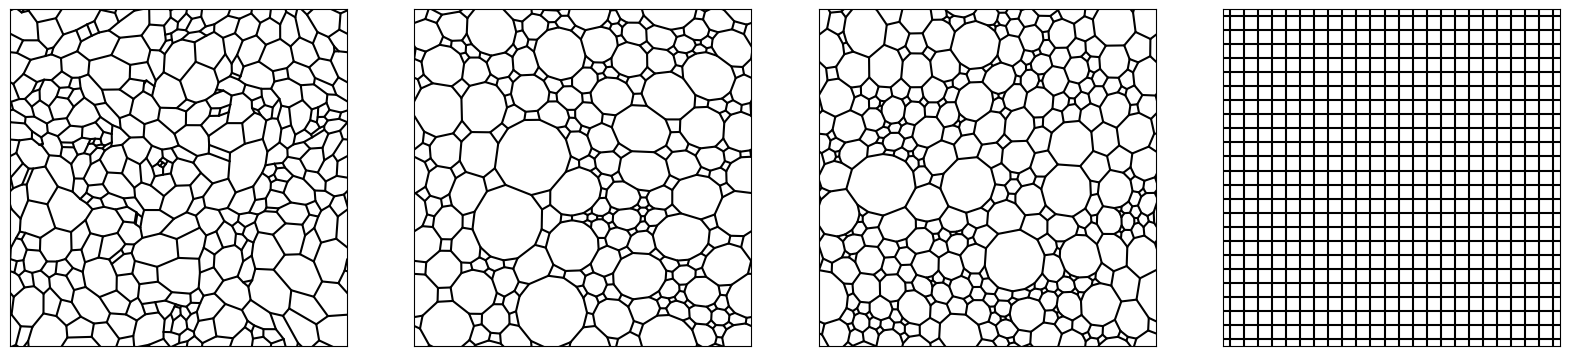

In [49]:
fig, ax = plt.subplots(1, len(lattices), figsize=(5 * len(lattices), 5))

for j, a in enumerate(ax):
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect("equal")
    pl.plot_edges(lattices[j], ax=a)

plt.savefig("lattices")

In [ ]:
results = []
for lattice in lattices:

    distances_from_center = np.linalg.norm(lattice.vertices.positions - 0.5, axis=1)
    central_vertex = np.argmin(distances_from_center)

    other_vertices = np.delete(np.arange(lattice.n_vertices), central_vertex)
    np.random.shuffle(other_vertices)

    step_distance = gu.distance_matrix(lattice)

    distances = []
    dimerisations = []

    for other_vertex in tqdm(other_vertices):
        to_remove = [central_vertex, other_vertex]
        monomer_lattice = gu.remove_vertices(copy(lattice), to_remove)

        distance_between = step_distance[*to_remove]
        if distance_between <= 2:
            continue
        if INVALID in lattice.vertices.adjacent_plaquettes[other_vertex]:
            continue
        # print(lattice.vertices.adjacent_plaquettes[other_vertex])

        n_dimers = find_kasteleyn_number(monomer_lattice)

        distances.append(distance_between)
        dimerisations.append(n_dimers)

    results.append((distances, dimerisations))

  1%|          | 3/599 [00:02<08:55,  1.11it/s]


KeyboardInterrupt: 

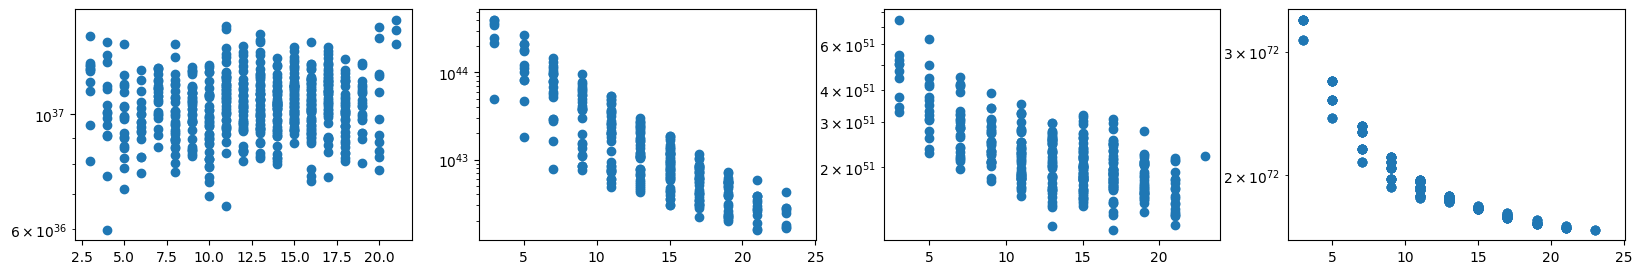

In [ ]:
fig, ax = plt.subplots(1, len(lattices), figsize=(5 * len(lattices), 3))

for j, a in enumerate(ax):
    a.set_yscale("log")

for j, res in enumerate(results):
    distances, dimerisations = res
    ax[j].scatter(distances, dimerisations)

plt.savefig("dimeristions")